In [1]:
%reload_ext autoreload
%autoreload 2

# Core imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import networkx as nx
import time
import psutil
import os
import sys
import gc
from tqdm import tqdm
from numpy.linalg import cond
import pickle
import json
from datetime import datetime

# GP framework imports
import torch
import gpytorch
from gpytorch import settings as gsettings
from gpytorch.kernels import MultiDeviceKernel
from linear_operator import settings
from linear_operator.utils import linear_cg
from linear_operator.operators import IdentityLinearOperator


# Custom imports
sys.path.append('../../..')
from efficient_graph_gp_sparse.preprocessor import GraphPreprocessor
from efficient_graph_gp_sparse.gptorch_kernels_sparse.sparse_grf_kernel import SparseGRFKernel
from efficient_graph_gp_sparse.utils_sparse import SparseLinearOperator


In [2]:
# GPyTorch / linear_operator settings
settings.verbose_linalg._default = True
settings._fast_covar_root_decomposition._default = False
gsettings.max_cholesky_size._global_value = 0
gsettings.cg_tolerance._global_value = 1e-2
gsettings.max_lanczos_quadrature_iterations._global_value = 1
settings.fast_computations.log_prob._state = True
gsettings.num_trace_samples._global_value = 64
gsettings.min_preconditioning_size._global_value = 1e10

In [3]:
sigma = 1
N = 10
G = nx.erdos_renyi_graph(n=N, p = 5 / N)

csr = nx.to_scipy_sparse_array(G)
pp = GraphPreprocessor(csr, walks_per_node=1000, p_halt=0.05, max_walk_length=10,use_tqdm=False, n_processes=10)
step_matrices_torch = pp.preprocess_graph(save_to_disk=False)
GRF = SparseGRFKernel(max_walk_length=10, step_matrices_torch=step_matrices_torch)
Phi = GRF._get_feature_matrix()
A = Phi + sigma**2 * IdentityLinearOperator(N)

A_dense = A @ torch.eye(N)
print(A_dense)
print(f"conditional number = {cond(A_dense.detach().numpy())}")

# Solve Phi @ x = b
b  = torch.randn(N)

with torch.no_grad():

    start_time = time.time()
    x, k = linear_cg(A._matmul, b, tolerance=1e-2, max_iter=1000, keep_k=True)
    end_time = time.time()
    print(f"time spent = {end_time-start_time}")
    print(f"num_iter = {k}")


/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/experiments_sparse/iterative_solvers/verify_convergence_rate/../../../efficient_graph_gp_sparse/preprocessor/graph_preprocessor.py:135: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([10, 1]) RHS for 1000 iterations (tol=0.01). Output: torch.Size([10, 1]).


tensor([[-2.7506e+00, -1.2669e+01, -9.2494e+00,  1.1555e+01, -8.7811e+00,
          2.9419e+00,  2.3366e-01,  9.9701e+00, -4.8787e+00,  5.7029e+00],
        [-7.3470e+00,  6.7767e+00, -2.9889e+00,  7.4059e+00, -5.5773e+00,
          1.2724e+01,  4.0573e+00, -4.0228e+00,  5.0981e+00,  3.4822e+01],
        [-5.4880e+00, -3.7523e+00, -3.7061e+00,  1.9896e+01, -9.5790e+00,
         -3.4380e+00,  1.0400e+01, -2.4880e+01, -1.6485e+01,  6.5067e+00],
        [ 2.0356e+01,  1.5846e+01,  4.2996e+00, -5.3977e+00,  2.9922e+00,
         -3.7476e+00, -7.9445e+00,  2.7209e+00, -2.0282e+00, -8.2595e+00],
        [-5.3798e+00, -1.5728e+01,  8.1736e+00, -6.4912e+01, -3.0079e+01,
          1.8362e+01, -1.9228e+01, -2.7365e+01, -7.5988e-01,  2.6164e+01],
        [-6.2985e+00, -8.9318e+00,  5.5811e+00, -6.9388e+00,  3.8433e+00,
         -2.1159e+01,  2.1522e+01, -5.2170e-02,  3.1485e+00, -3.5347e+00],
        [ 7.8666e+01, -1.7609e+00,  2.3222e+01,  2.2779e+01,  1.0417e+00,
         -2.0654e+01, -2.0764e+0

/scratches/cartwright/mz473/Efficient-Gaussian-Process-on-Graphs/venv/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:339: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2040164992.0 which is larger than the tolerance of 0.01 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


In [4]:
sigma = 1.0
sizes = [2**k for k in range(0, 11)]   # 1,2,4,...,1024
n_repeats = 10

records = []

for N in tqdm(sizes):
    for rep in range(n_repeats):
        np.random.seed(rep)
        torch.manual_seed(rep)

        G = nx.erdos_renyi_graph(n=N, p=2.0 / N, seed=rep)
        csr = nx.to_scipy_sparse_array(G)

        pp = GraphPreprocessor(
            csr,
            walks_per_node=10000,
            p_halt=0.1,
            max_walk_length=5,
            use_tqdm=False,
            n_processes=10,
        )

        step_matrices = pp.preprocess_graph(save_to_disk=False)
        GRF = SparseGRFKernel(max_walk_length=5, step_matrices_torch=step_matrices)

        Phi = GRF._get_feature_matrix()
        A = Phi + sigma**2 * torch.eye(Phi.shape[0])

        A_dense = A @ torch.eye(Phi.shape[0])
        A_np = A_dense.detach().numpy()
        c = cond(A_np)

        records.append({
            "N": N,
            "repeat": rep,
            "cond": c
        })

df = pd.DataFrame(records)
df.to_csv("cond.csv", index=False)

df

100%|██████████| 11/11 [07:57<00:00, 43.44s/it] 


,N,repeat,cond
0,1,0,1.000000
1,1,1,1.000000
2,1,2,1.000000
3,1,3,1.000000
4,1,4,1.000000
...,...,...,...
105,1024,5,710.438416
106,1024,6,448.529083
107,1024,7,1728.840576
108,1024,8,9412.497070


<>:72: SyntaxWarning: invalid escape sequence '\k'
<>:72: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_3873430/3959536982.py:72: SyntaxWarning: invalid escape sequence '\k'
  label=f"Fit: $\kappa \sim N^{{{slope:.2f}}}$", alpha=0.8)


Fitted exponent (slope): 0.9688930817995469
Intercept: 1.328204513941126


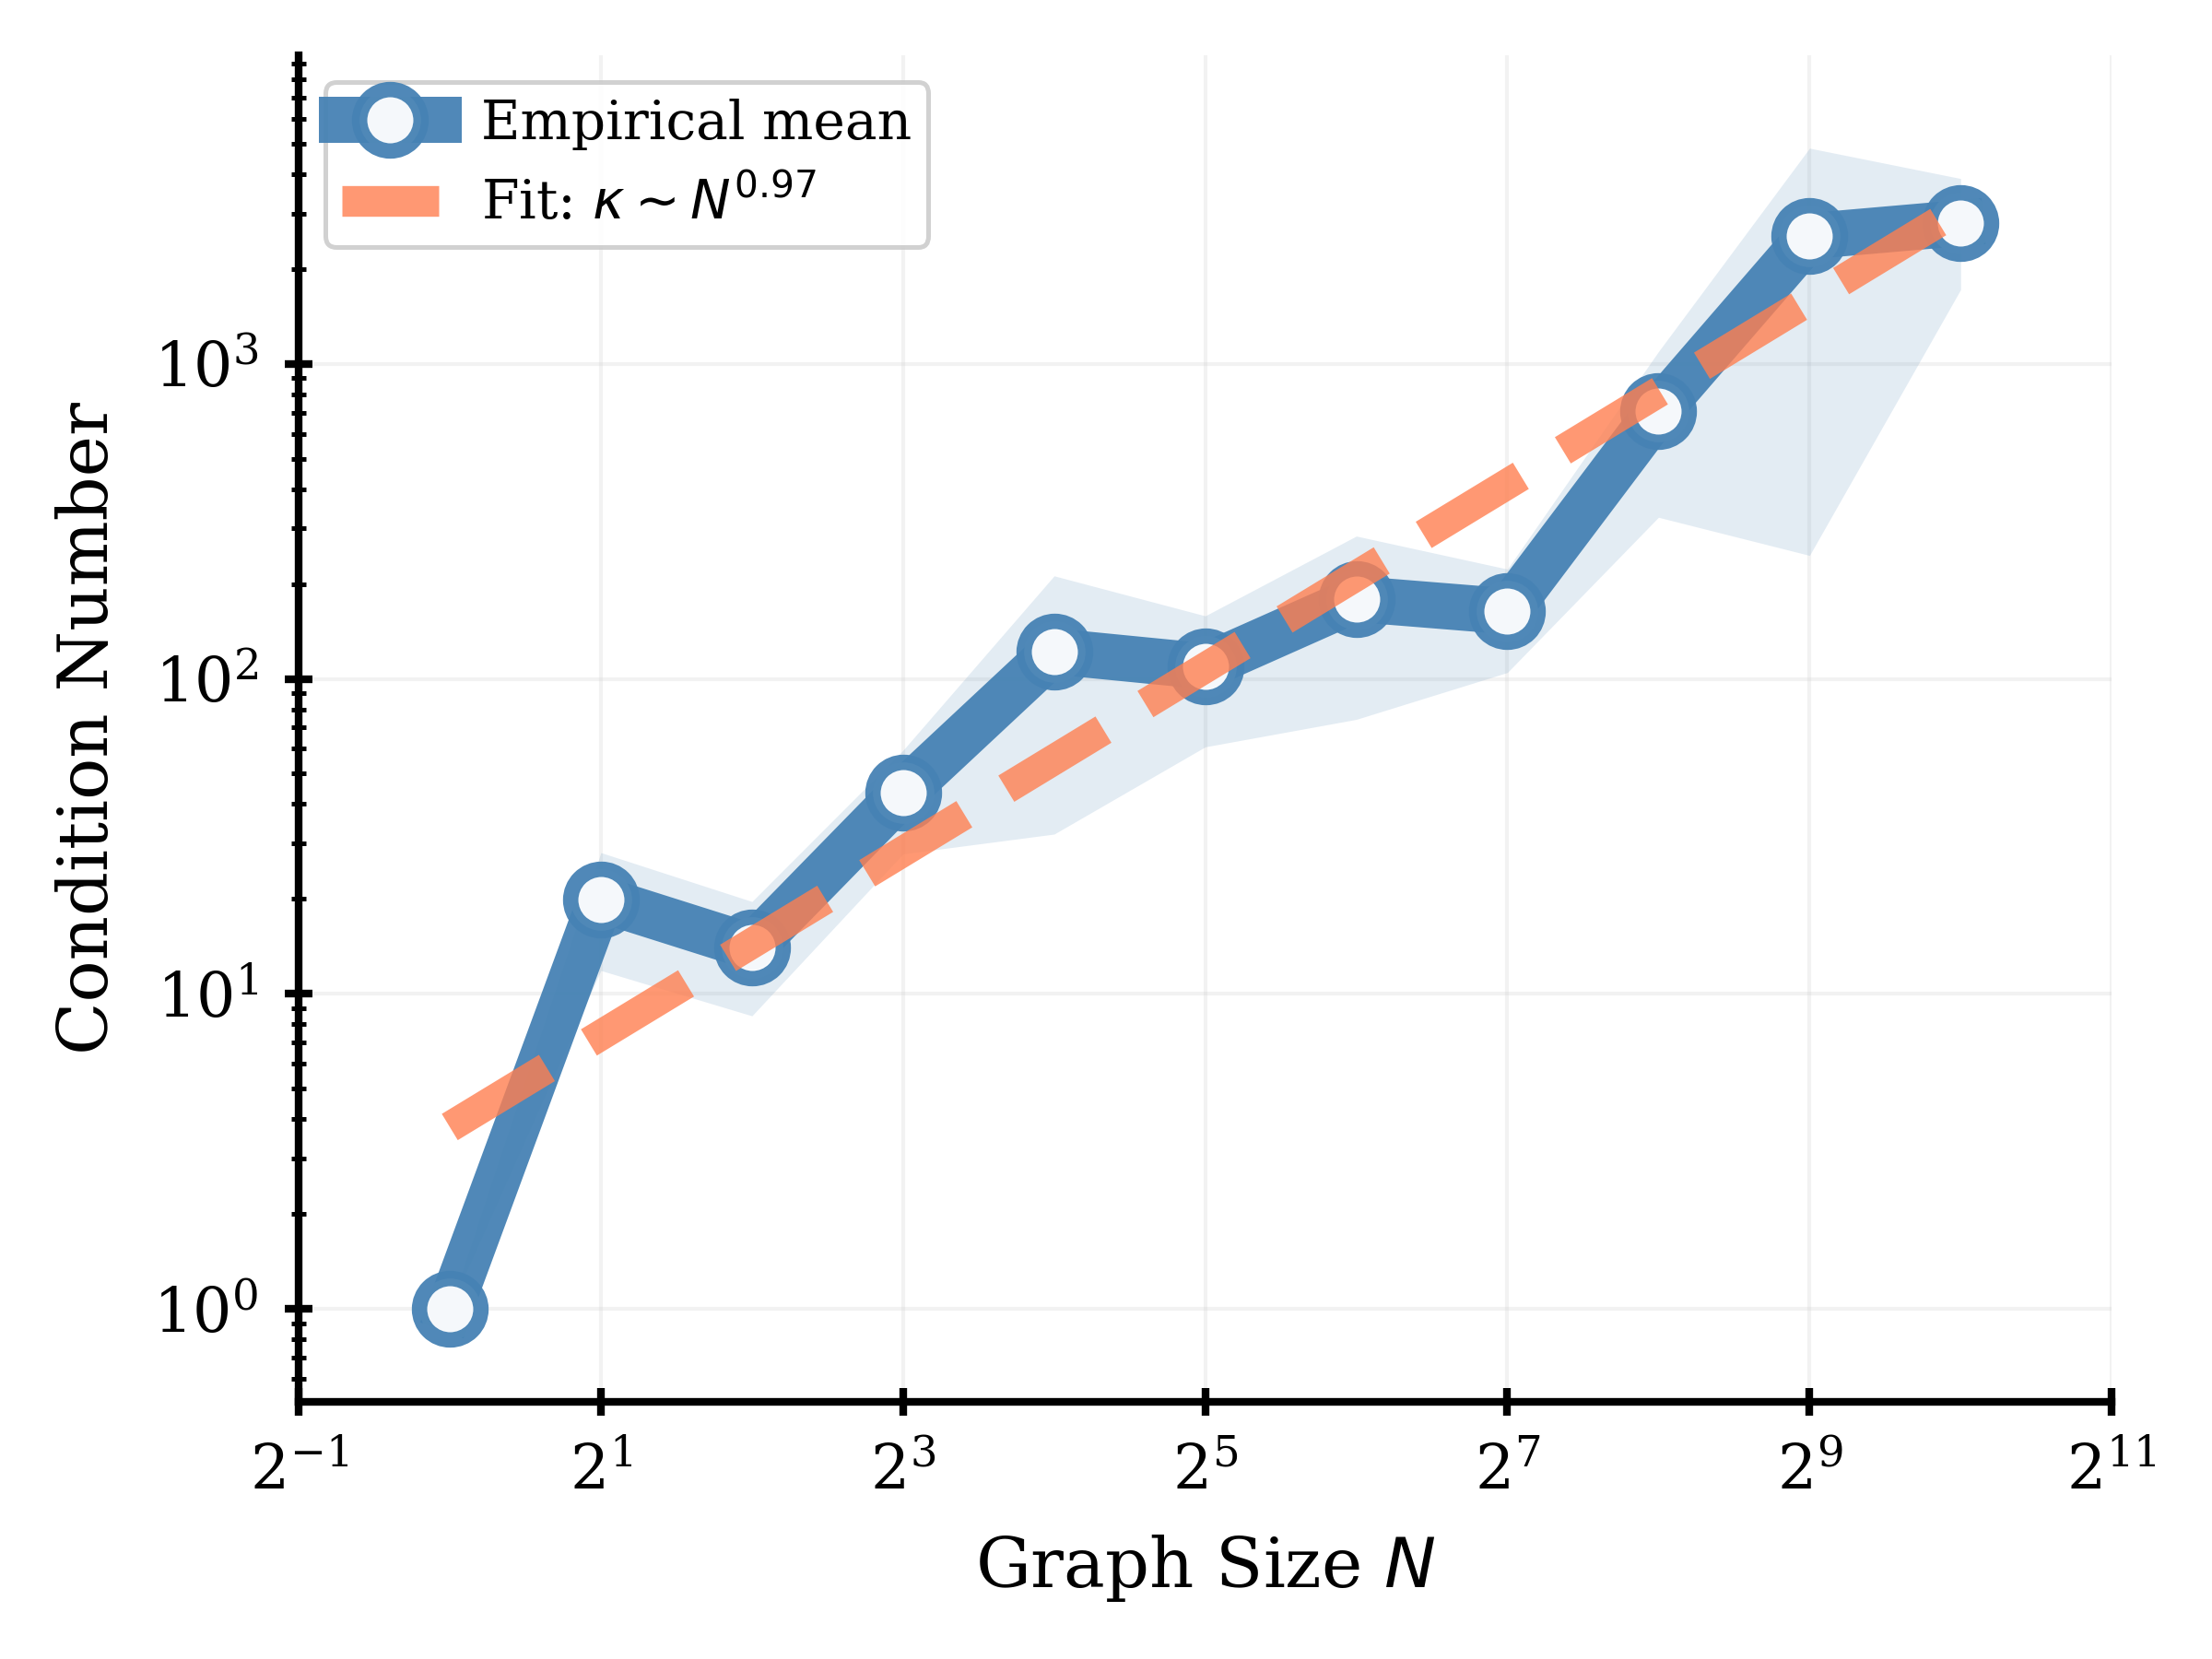

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load the saved results
df = pd.read_csv("cond.csv")

# group results
grouped = df.groupby("N")["cond"].agg(["mean", "std"]).reset_index()

# prepare log-log data for fitting
x = np.log(grouped["N"].values)
y = np.log(grouped["mean"].values)

# linear fit: log(cond) = a * log(N) + b
slope, intercept = np.polyfit(x, y, 1)

print(f"Fitted exponent (slope): {slope}")
print(f"Intercept: {intercept}")

# Set publication-style formatting
import matplotlib as mpl
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"],
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 7,
    "axes.linewidth": 1.0,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.25,
    "axes.axisbelow": True,
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

# plot mean ± std on log-log axes
fig, ax = plt.subplots(figsize=(4, 3))

# Compute standard error
grouped['stderr'] = grouped['std'] / np.sqrt(10)  # n_repeats = 10

# Plot shaded uncertainty band
ax.fill_between(
    grouped["N"], 
    grouped["mean"] - grouped["stderr"], 
    grouped["mean"] + grouped["stderr"],
    color='steelblue', alpha=0.15, linewidth=0, zorder=1
)

# Plot mean curve
ax.plot(
    grouped["N"], grouped["mean"],
    marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2,
    linestyle='-', linewidth=6, color='steelblue', alpha=0.95,
    label='Empirical mean', zorder=2
)

# overlay fitted power-law curve
N_dense = np.linspace(grouped["N"].min(), grouped["N"].max(), 200)
fit_curve = np.exp(intercept) * (N_dense ** slope)
ax.plot(N_dense, fit_curve, '--', linewidth=4, color='coral', 
        label=f"Fit: $\kappa \sim N^{{{slope:.2f}}}$", alpha=0.8)

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Graph Size $N$")
ax.set_ylabel("Condition Number")
ax.grid(True, which="major", axis='both')
ax.grid(False, which="minor")

# Turn off minor ticks
ax.minorticks_off()

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

leg = ax.legend(loc='upper left', frameon=True, framealpha=0.9,
               fancybox=True, borderpad=0.3, handlelength=1.8)
leg.get_frame().set_linewidth(0.6)

ax.margins(x=0.10, y=0.08)
plt.tight_layout(pad=0.8)
plt.show()